In [30]:
#Fuente: https://www.youtube.com/watch?v=i8c_GRQ3H9E&t=270s
#Dataset: https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [38]:
#Cargar los datos
datos = pd.read_csv('CVD_cleaned.csv')
datos.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [39]:
# Limpiar Datos
# Obtener las columnas no numéricas con valores únicos
columnas_no_numericas = datos.select_dtypes(exclude=[np.number]).columns
diccionario_mapeo = {}

# Mapear las columnas no numéricas con valores únicos a enteros
for columna in columnas_no_numericas:
    valores_unicos = datos[columna].unique()
    diccionario_mapeo[columna] = {valor: indice for indice, valor in enumerate(valores_unicos)}
    datos[columna] = datos[columna].map(diccionario_mapeo[columna])

# Imputar los valores faltantes con la media de cada columna numérica
columnas_numericas = datos.select_dtypes(include=[np.number]).columns
datos[columnas_numericas] = datos[columnas_numericas].fillna(datos[columnas_numericas].mean())
datos.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0,0,0,0,0,0,0,0,0,0,0,150.0,32.66,14.54,0,0.0,30.0,16.0,12.0
1,1,1,0,1,0,0,0,1,1,0,0,165.0,77.11,28.29,1,0.0,30.0,0.0,4.0
2,1,1,1,0,0,0,0,1,1,0,1,163.0,88.45,33.47,1,4.0,12.0,3.0,16.0
3,0,1,1,1,0,0,0,1,1,1,2,180.0,93.44,28.73,1,0.0,30.0,30.0,8.0
4,2,1,0,0,0,0,0,0,1,1,3,191.0,88.45,24.37,0,0.0,8.0,4.0,0.0


In [40]:
# Separamos la ultima columna para que sea variable destino
datos_y = datos['Heart_Disease']
datos_y.head()

0    0
1    1
2    0
3    1
4    0
Name: Heart_Disease, dtype: int64

In [41]:
# Eliminamos las columnas que no funcionarán
datos_x = datos.drop(columns=['Heart_Disease'])
datos_x.head()

,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0,0,0,0,0,0,0,0,0,0,150.0,32.66,14.54,0,0.0,30.0,16.0,12.0
1,1,1,0,0,0,0,1,1,0,0,165.0,77.11,28.29,1,0.0,30.0,0.0,4.0
2,1,1,1,0,0,0,1,1,0,1,163.0,88.45,33.47,1,4.0,12.0,3.0,16.0
3,0,1,1,0,0,0,1,1,1,2,180.0,93.44,28.73,1,0.0,30.0,30.0,8.0
4,2,1,0,0,0,0,0,1,1,3,191.0,88.45,24.37,0,0.0,8.0,4.0,0.0


In [42]:
#Dividir datos entre entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.2, random_state=2)
print(
    "X Train: {}, X Test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
n_entradas = X_train.shape[1]
#registro/columnas

X Train: (247083, 18), X Test: (61771, 18), y_train: (247083,), y_test: (61771,)


In [43]:
#Ahora vamos a escalar los valores para que esten dentro de un rango mas corto.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
#Para poder procesar los datos en la red neuronal necesitamos que todos los datos estén en tensores, asi que haremos las conversiones necesarias
t_X_train = torch.from_numpy(X_train).float().to("cpu")  #MPS
t_X_test = torch.from_numpy(X_test).float().to("cpu")
t_y_train = torch.from_numpy(y_train.values).float().to("cpu")
t_y_test = torch.from_numpy(y_test.values).float().to("cpu")
t_y_train = t_y_train[:, None]
t_y_test = t_y_test[:, None]

In [45]:
#Ahora vamos a crear el modelo de la red neuronal
#mi data set es para saber si es que una persona tiene probabilidad de tener problemas cardiacos, quiero saber si la respuesta es si o no
class Modelo(nn.Module):
    def __init__(self, n_entradas):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 15)  #variable/salida
        self.linear2 = nn.Linear(15, 10)
        self.linear3 = nn.Linear(10, 1)

    def forward(self, inputs):
        pred_1 = torch.sigmoid(input=self.linear1(inputs))
        pred_2 = torch.sigmoid(input=self.linear2(pred_1))
        pred_final = torch.sigmoid(input=self.linear3(pred_2))
        return pred_final

In [46]:
#Entrenamiento
learning_rate = 0.01
epochs = 1000
estatus_print = 100  #cada 100 epocas imprimimos el estatus del entrenamiento de modelo

model = Modelo(n_entradas=n_entradas)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  #algoritmo de optimizacion
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()  #se guarda informacion del entrenamiento para poder graficar
print("Entrenando modelo...")
for epoch in range(1, epochs + 1):
    y_pred = model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)  #se compara predicciones con valores reales
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)
print("Accuracy final: {}".format(round(accuracy.item(), 4)))

Arquitectura del modelo: Modelo(
  (linear1): Linear(in_features=18, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)
Entrenando modelo...

Epoch 100 	 Loss: 0.2548
Accuracy: 92.01405334472656

Epoch 200 	 Loss: 0.2457
Accuracy: 92.01405334472656

Epoch 300 	 Loss: 0.242
Accuracy: 92.01405334472656

Epoch 400 	 Loss: 0.2396
Accuracy: 92.01405334472656

Epoch 500 	 Loss: 0.2376
Accuracy: 92.01405334472656

Epoch 600 	 Loss: 0.2359
Accuracy: 92.01405334472656

Epoch 700 	 Loss: 0.2347
Accuracy: 92.01405334472656

Epoch 800 	 Loss: 0.2338
Accuracy: 92.01405334472656

Epoch 900 	 Loss: 0.233
Accuracy: 92.01405334472656

Epoch 1000 	 Loss: 0.232
Accuracy: 92.01405334472656
Accuracy final: 92.0141


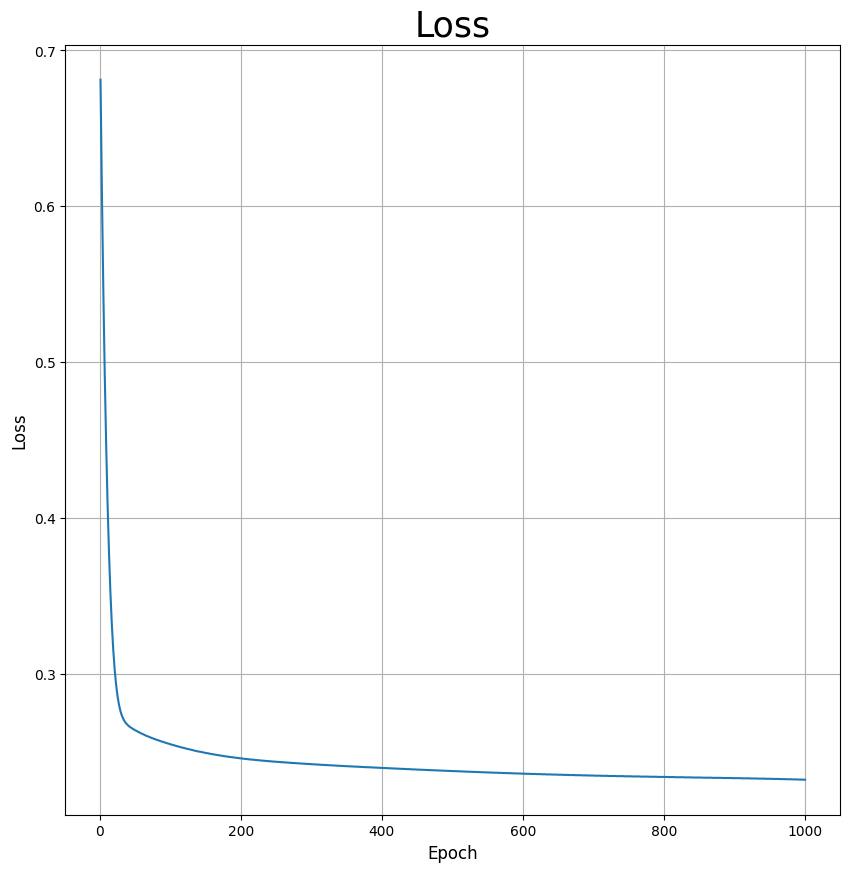

In [47]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()

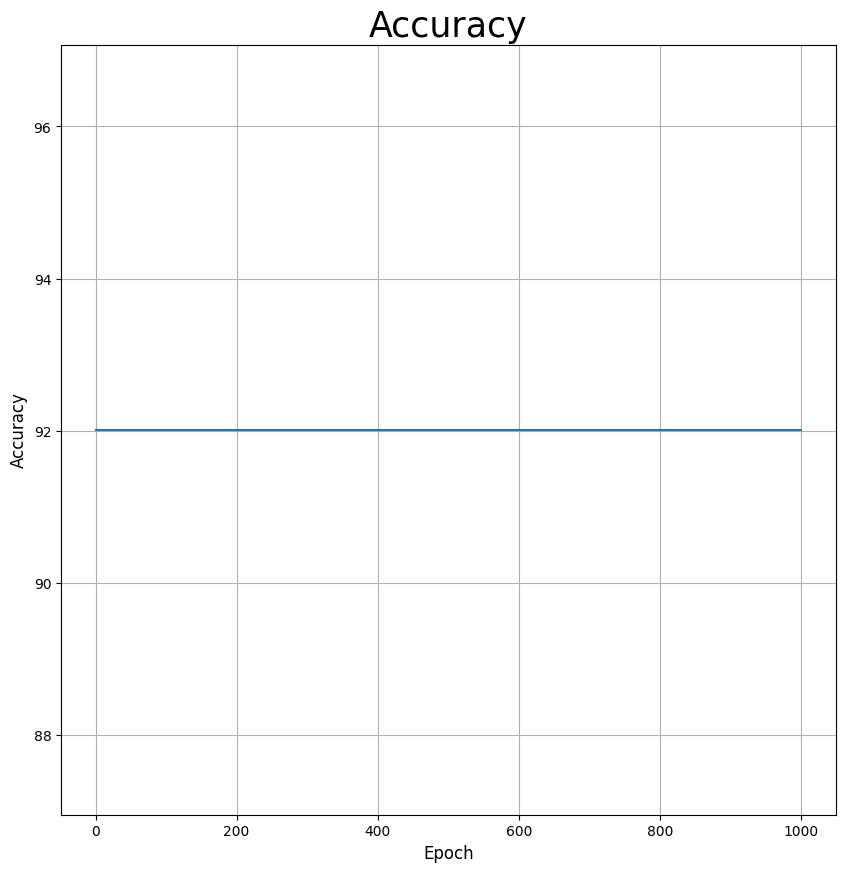

In [48]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()